In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb

In [150]:
housing_data = pd.read_csv('DatenAusgegeben1.2_UTF8_manuell.csv', sep=";", keep_default_na=False)
# print(housing_data.keys())

# Feature Engeneering für €/qm² für besseren Vergleich der Daten
housing_data["Preisproqm"] = housing_data["Preis"]/housing_data["Wohnflaeche in qm"]
# Werte der Heizungsqualitaet in Zahlen umwandeln
housing_data["Heizungsqualitaet"] = [1 if x=="Schl" else 2 if x=="Ud" else 3 if x=="Ty" else 4 if x=="Gut" else 5 for x in housing_data["Heizungsqualitaet"]]
# monate seit 2136
housing_data["Monate"] = (housing_data["Verkaufsjahr"]-2136)*12 + housing_data["Verkaufsmonat"] -1

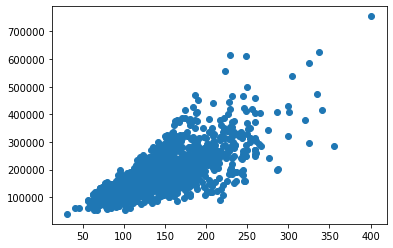

In [4]:
plt.scatter(housing_data["Wohnflaeche in qm"],housing_data["Preis"])
# Hierfür Lineare Regression!

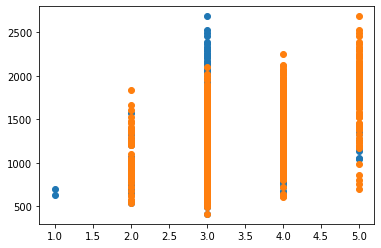

In [35]:
plt.scatter(housing_data["Zustand Fassade"],housing_data["Preis"]/housing_data["Wohnflaeche in qm"])
plt.scatter(housing_data["Kuechenqualitaet"],housing_data["Preis"]/housing_data["Wohnflaeche in qm"])


In [18]:
housing_data.keys()

Index(['Grundstueck in qm', 'Grundstuecksform', 'Steigung', 'Bezirk', 'Zone',
       'Lage', 'Typ', 'Zustand', 'Gebaut', 'Renoviert', 'Zustand Fassade',
       'Kellerflaeche in qm', 'Heizung', 'Heizungsqualitaet', 'Klimaanlage',
       'Erster Stock in qm', 'Zweiter Stock in qm', 'Wohnflaeche in qm',
       'Schlafzimmer', 'Kuechen', 'Kuechenqualitaet', 'Raeume', 'Garage Typ',
       'Garagenkapazitaet', 'Pool', 'Verkaufsmonat', 'Verkaufsjahr', 'Preis'],
      dtype='object')

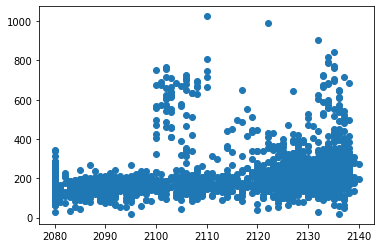

In [19]:
plt.scatter(housing_data["Renoviert"],housing_data["Preis"]/housing_data["Grundstueck in qm"])

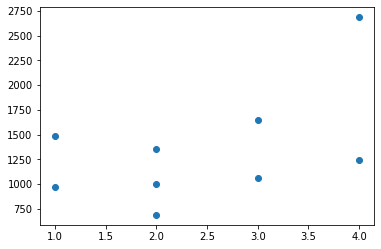

In [47]:
plt.scatter(housing_data["Pool"],housing_data["Preis"]/housing_data["Wohnflaeche in qm"])


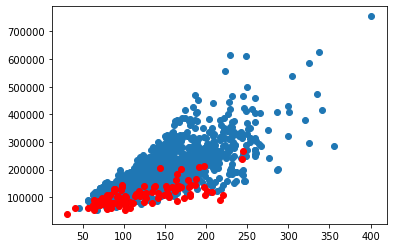

In [54]:
#Klimaanlage
house_ac = housing_data[housing_data.Klimaanlage == "Y"]
house_not_ac = housing_data[housing_data.Klimaanlage == "N"]
plt.scatter(house_ac["Wohnflaeche in qm"],house_ac["Preis"])
plt.scatter(house_not_ac["Wohnflaeche in qm"],house_not_ac["Preis"],c="red")


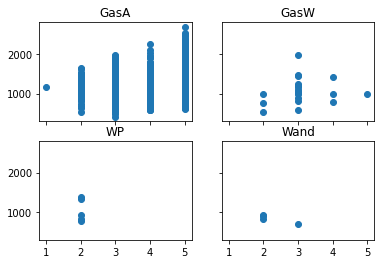

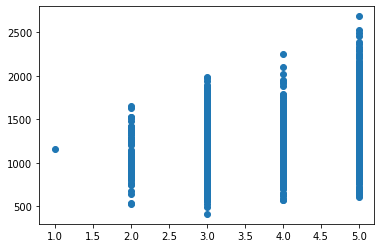

In [33]:
# Florian:
# Heizung, Heizungsqualitaet, Erster Stock in qm, Zweiter Stock in qm, Wohnflaeche in qm, Schlafzimmer, Kuechen, Kuechenqualität, Räume, Garage Typ, Garagenkapazitt, Verkaufsmonat, Verkaufsjahr, Preis
# untersuchen

# Heizung + Qualitaet
heater_types = housing_data["Heizung"].unique()

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
for i in range(4):
    heater_data = housing_data[housing_data["Heizung"] == heater_types[i]]
    axs[int(i/2),i%2].scatter(heater_data["Heizungsqualitaet"], heater_data["Preisproqm"])
    axs[int(i/2),i%2].set_title(heater_types[i])
# wie man sehen kann, gibt es nur für die Klimaanlage genügend Werte
# Auch hat die Qualität der Heizung nur bei Klimaanlagen annähernd einen Einfluss
plt.show()
plt.scatter(housing_data["Heizungsqualitaet"], housing_data["Preisproqm"])
# Auch der Überblick nur über die Heizungsqualitaet hat keinen großen Einfluss auf den €/m²

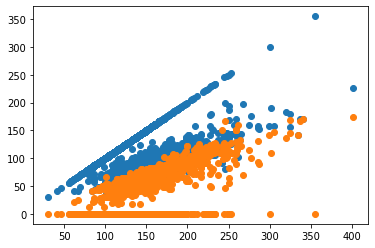

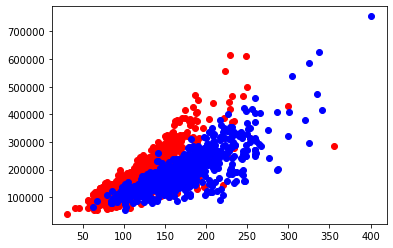

In [49]:
# Erster Stock in qm, Zweiter Stock in qm, Wohnflaeche in qm
# Daten für uns unwichtig, es wird nur kurz darüber geschaut, ob Anomalien und interessante Sachen auftreten

plt.scatter(housing_data["Wohnflaeche in qm"], housing_data["Erster Stock in qm"])
plt.scatter(housing_data["Wohnflaeche in qm"], housing_data["Zweiter Stock in qm"])
plt.show()
# Wie zu erwarten sieht man nicht viel, es gibt sehr viele einstöckige Häuser

one_floor = housing_data[housing_data["Zweiter Stock in qm"] == 0 ]
two_floors = housing_data[housing_data["Zweiter Stock in qm"] != 0 ]

plt.scatter(one_floor["Wohnflaeche in qm"], one_floor["Preis"], c= "red")
plt.scatter(two_floors["Wohnflaeche in qm"], two_floors["Preis"], c= "blue")
# Wohnungen mit mehreren Stockwerken sind bei gleicher Wohnfläche durchweg billiger

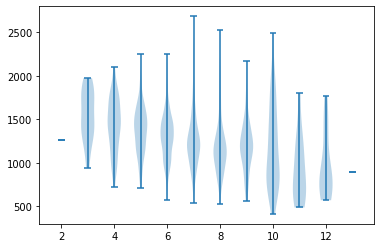

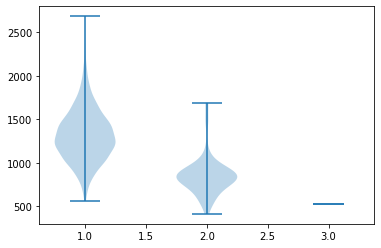

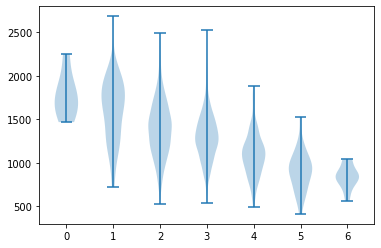

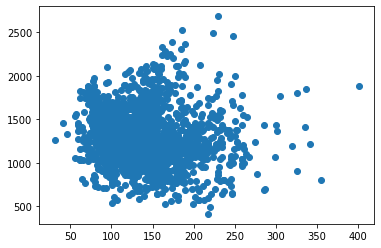

In [111]:
# Schlafzimmer, Kuechen, Räume

# idee: je mehr Räume im Vergleich zu Wohnfläche -> billiger

rooms = np.sort(housing_data["Raeume"].unique())
room_data = [None]*len(rooms)
for i in range(len(rooms)):
    room_data[i] = housing_data[housing_data["Raeume"] == rooms[i]]["Preisproqm"]


plt.violinplot(room_data, rooms)
plt.show()
# ideale Raumzahl liegt bei 7/8 Raeumen

kitchens = np.sort(housing_data["Kuechen"].unique())
kitchen_data = [None]*len(kitchens)
for i in range(len(kitchens)):
    kitchen_data[i] = housing_data[housing_data["Kuechen"] == kitchens[i]]["Preisproqm"]

plt.violinplot(kitchen_data, kitchens)
plt.show()
# Die Anzahl der Kuechen haben wohl keinen Einfluss, oder 1 Kueche > 2?


bedrooms = np.sort(housing_data["Schlafzimmer"].unique())
bedroom_data = [None]*len(bedrooms)
for i in range(len(bedrooms)):
    bedroom_data[i] = housing_data[housing_data["Schlafzimmer"] == bedrooms[i]]["Preisproqm"]

plt.violinplot(bedroom_data, bedrooms)
plt.show()
# Die Anzahl der Schlafzimmer ist komisch, 1 Schlafzimmer ist am beliebtesten? Vllt sind sehr kleine Wohnflächen teurerer als im Vergleich?
plt.scatter(housing_data["Wohnflaeche in qm"],housing_data["Preisproqm"])
# Schwer zu sagen, wahrscheinlich aber nicht


['Anbau' 'Freistehend' 'Eingebaut' 'NA' 'TG' '2Typen' 'CarPort']


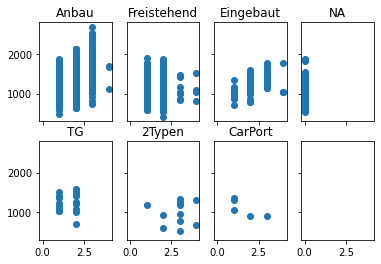

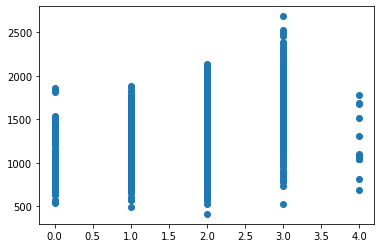

In [142]:
#Garage Typ, Garagenkapazitaet
# warhscheinlich -> mehr Garagen -> teurer?
# Heizung + Qualitaet
garage_types = housing_data["Garage Typ"].unique()
print(garage_types)

fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)

for i in range(len(garage_types)):
    garage_data = housing_data[housing_data["Garage Typ"] == garage_types[i]]
    axs[int(i/4),i%4].scatter(garage_data["Garagenkapazitaet"], garage_data["Preisproqm"])
    axs[int(i/4),i%4].set_title(garage_types[i])
plt.show()
# Anbaugaragen sind mitunter am teuersten, wobei die anderen im €/qm Bereich sind, wie, wenn keine Garage vorhanden ist
# Der Einfluss von Garagen auf den Preis ist nicht signifikant

plt.scatter(housing_data["Garagenkapazitaet"], housing_data["Preisproqm"])
# Auch der Überblick nur über die Garagenkapazitaet hat keinen großen Einfluss auf den €/m²

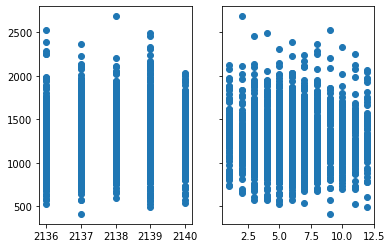

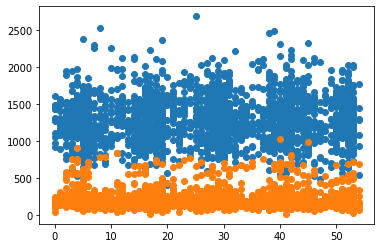

In [157]:
# Verkaufsmonat, Verkaufsjahr, Preis
# Verkaufsmonat sollte weniger einfluss auf den Preis haben
# Verkaufsjahr sollte einen Anstieg wegen der Erhöhung der Mietpreise aufzeigen
fig, axs = plt.subplots(1, 2, sharey=True)


axs[0].scatter(housing_data["Verkaufsjahr"],housing_data["Preisproqm"])
axs[1].scatter(housing_data["Verkaufsmonat"], housing_data["Preisproqm"])
plt.show()
plt.scatter(housing_data["Monate"],housing_data["Preisproqm"])
plt.scatter(housing_data["Monate"],housing_data["Preis"]/housing_data["Grundstueck in qm"])
plt.show()
# es gibt keinen Anstieg zwischen den Jahren
# Es werden teurere Wohnungen in den Sommermonaten verkauft